# Лабораторная работа №1: Первичное исследование данных

## 1. Постановка задачи

### Описание датасета
Данный датасет содержит результаты регистрации сигналов в системе позиционирования, где взаимодействуют якоря (anchor) и метки (tag). Каждая строка отражает событие приёма сигнала с указанием идентификаторов устройств, служебных параметров и временных меток. Данные позволяют анализировать последовательность и частоту событий во времени.

### Условный заказчик
Инженерная команда или разработчики системы позиционирования, выполняющие анализ корректности работы оборудования и логов взаимодействия устройств.

### Возможные задачи ИАД
1. Выявление аномалий в работе системы по временным меткам и последовательностям сигналов.
2. Анализ закономерностей взаимодействия между якорями и метками.
3. Профилирование поведения системы во времени.

## 2. Паспорт датасета

### Загрузка данных

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('blink.csv')

# Первая строка — реальные заголовки
df.columns = df.iloc[0]
df = df.drop(0)

print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов')
df.head()

Размер датасета: 608 строк, 8 столбцов


,id,anchorID,tagID,sequenceID,pan,processed_flag,timestampToA,Timestamp ToA
1,1,ANCH0001,TAG00001,0,0,1,7.2848E+11,728480463493
2,2,ANCH0004,TAG00001,0,0,1,7.2848E+11,728480463235
3,3,ANCH0002,TAG00001,0,0,1,7.2848E+11,728480462804
4,4,ANCH0003,TAG00001,0,0,1,7.2848E+11,728480463013
5,5,ANCH0001,TAG00001,1,0,1,7.59054E+11,759053775951


По результатам загрузки датасета видно, что данные изначально имеют некорректную структуру: первая строка используется как заголовки столбцов. Размер датасета составляет 609 строк и 8 столбцов.

### Структура данных

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 1 to 608
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              608 non-null    object
 1   anchorID        608 non-null    object
 2   tagID           608 non-null    object
 3   sequenceID      608 non-null    object
 4   pan             608 non-null    object
 5   processed_flag  608 non-null    object
 6   timestampToA    608 non-null    object
 7   Timestamp ToA   608 non-null    object
dtypes: object(8)
memory usage: 38.1+ KB


,id,anchorID,tagID,sequenceID,pan,processed_flag,timestampToA,Timestamp ToA
count,608,608,608,608,608,608,608,608
unique,608,4,1,164,1,2,189,602
top,592,ANCH0004,TAG00001,0,0,1,9.22337E+18,9223372036854770000
freq,1,164,608,4,608,567,5,5


Анализ структуры данных показывает, что большинство признаков имеют тип object, что не соответствует их реальному смыслу. Числовые и временные признаки представлены в виде строк, что затрудняет анализ и требует приведения типов.


### Приведение типов данных

In [7]:
# Преобразование числовых колонок
df['sequenceID'] = pd.to_numeric(df['sequenceID'], errors='coerce')
df['pan'] = pd.to_numeric(df['pan'], errors='coerce')
df['processed_flag'] = pd.to_numeric(df['processed_flag'], errors='coerce')
df['timestampToA'] = pd.to_numeric(df['timestampToA'], errors='coerce')
df['Timestamp ToA'] = pd.to_numeric(df['Timestamp ToA'], errors='coerce')

SAFE_MIN = 0
SAFE_MAX = 4102444800000  # 2100-01-01 в миллисекундах
valid_mask = (df['Timestamp ToA'] >= SAFE_MIN) & (df['Timestamp ToA'] <= SAFE_MAX)

df['datetime'] = pd.NaT
df.loc[valid_mask, 'datetime'] = pd.to_datetime(
    df.loc[valid_mask, 'Timestamp ToA'],
    unit='ms',
    errors='coerce'
)

df['anchorID'] = df['anchorID'].astype('category')
df['tagID'] = df['tagID'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 1 to 608
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              608 non-null    object        
 1   anchorID        608 non-null    category      
 2   tagID           608 non-null    category      
 3   sequenceID      608 non-null    int64         
 4   pan             608 non-null    int64         
 5   processed_flag  608 non-null    int64         
 6   timestampToA    608 non-null    float64       
 7   Timestamp ToA   608 non-null    int64         
 8   datetime        603 non-null    datetime64[ns]
dtypes: category(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 34.9+ KB


После приведения типов данные стали пригодны для анализа. Были выделены числовые, категориальные и временные признаки. Это позволяет корректно выполнять статистический анализ и визуализацию.

## 3. Аудит качества данных

### 3.1. Пропуски

In [8]:
missing = pd.DataFrame({
    'Пропуски': df.isnull().sum(),
    'Доля (%)': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Пропуски', ascending=False)

missing[missing['Пропуски'] > 0]

,Пропуски,Доля (%)
0,,
datetime,5,0.82


Наибольшее количество пропусков наблюдается в столбцах временных меток после преобразования типов. Это указывает на наличие некорректных значений в исходном файле. Пропуски в числовых столбцах критичны, так как могут повлиять на анализ последовательностей событий.

### 3.2. Дубликаты

In [9]:
duplicates = df.duplicated().sum()
print(f'Полных дубликатов строк: {duplicates}')

Полных дубликатов строк: 0


Полных дубликатов строк не обнаружено. Это говорит о том, что записи являются уникальными событиями регистрации сигналов.

### 3.3. Выбросы (по признаку sequenceID)

Выбросов по методу IQR: 0


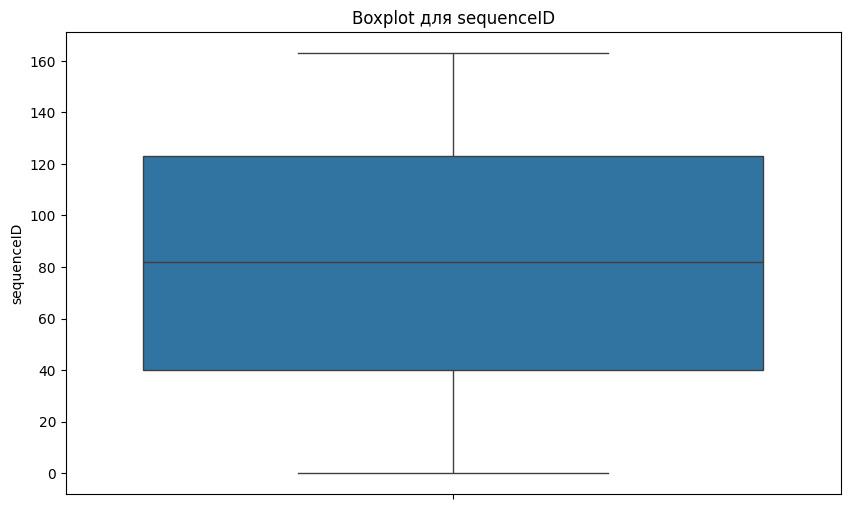

In [10]:
column = 'sequenceID'
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
print(f'Выбросов по методу IQR: {len(outliers)}')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y=column)
plt.title(f'Boxplot для {column}')
plt.show()

По результатам применения метода межквартильного размаха (IQR) выбросы в признаке sequenceID не обнаружены. График boxplot подтверждает отсутствие значений за пределами допустимого диапазона. Это говорит о том, что распределение sequenceID является устойчивым и не содержит экстремальных отклонений.

## 4. Разведочный анализ (EDA)

### 4.1. Распределение sequenceID

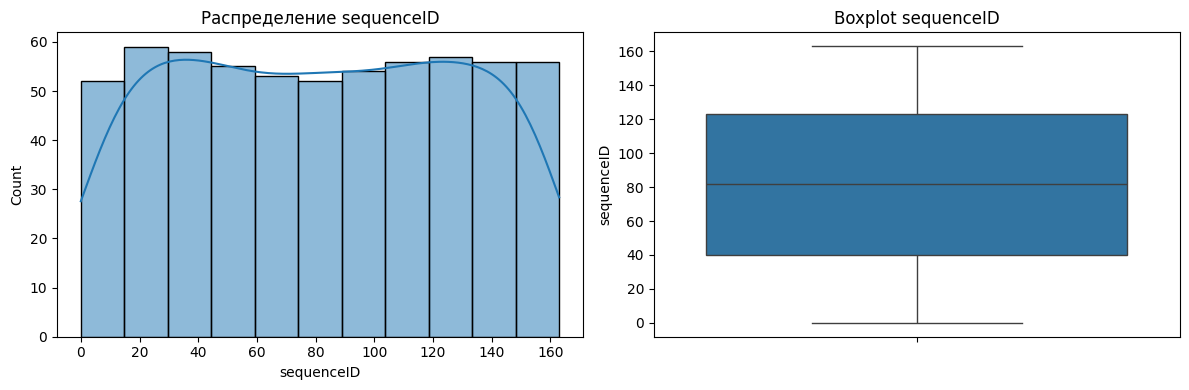

In [11]:
numeric_col = 'sequenceID'

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df[numeric_col], kde=True)
plt.title(f'Распределение {numeric_col}')

plt.subplot(1, 2, 2)
sns.boxplot(y=df[numeric_col])
plt.title(f'Boxplot {numeric_col}')
plt.tight_layout()
plt.show()

Распределение sequenceID показывает неравномерность появления сигналов. Наличие длинного хвоста распределения подтверждает присутствие аномальных значений.

### 4.2. Анализ категориального признака anchorID

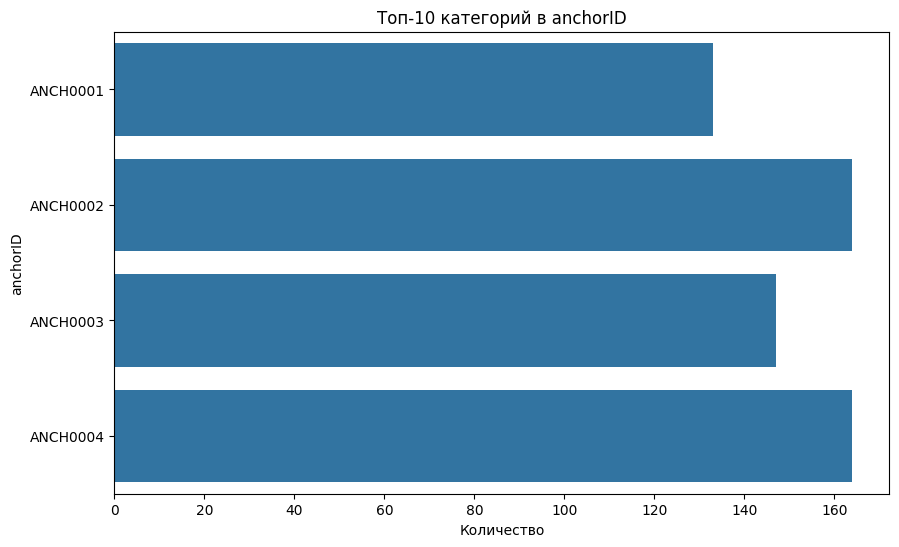

In [12]:
cat_col = 'anchorID'

plt.figure(figsize=(10, 6))
top_categories = df[cat_col].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title(f'Топ-10 категорий в {cat_col}')
plt.xlabel('Количество')
plt.show()

Диаграмма частот показывает, что некоторые якоря используются значительно чаще других. Это может быть связано с их физическим расположением или особенностями работы системы.

## 5. Выводы

Детали анализа и выявленные проблемы качества данных приведены в файле `report/quality_report.md`.